<a href="https://colab.research.google.com/github/superp0tat0/Algorithms/blob/master/MNIST_PCA_regularized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Feb 19 20:02:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.datasets import fashion_mnist
from keras.datasets import cifar10
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.model_selection import train_test_split

# import some additional tools
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

def model_status(model):
    for layer in model.layers:
      print(layer, layer.trainable)

def build_model_single_dense(first_layer_neuron = 32):
  model = Sequential()                                 # Linear stacking of layers
  model.add(Dense(first_layer_neuron))                
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(10))                                 # final 10 FCN nodes
  model.add(Activation('softmax'))                     # softmax activation
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def build_model_complex_dense():
  model = Sequential()                                 # Linear stacking of layers
  model.add(Dense(32))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(64))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(128))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(64))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(32))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(10))                                 # final 10 FCN nodes
  model.add(Activation('softmax'))                     # softmax activation
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [3]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = np.mean(X_train, axis = -1)
X_test = np.mean(X_test, axis = -1)

#Flatten the X data for PCA features
X_train_Flatten = X_train.reshape(50000, 32*32)
X_test_Flatten = X_test.reshape(10000, 32*32)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

nb_classes = 10 # number of unique digits
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
y_random = np.array([random.randint(0,9) for i in range(60000)])
Y_random = np_utils.to_categorical(y_random, nb_classes)

170500096/170498071 [==============================] - 3s 0us/step


In [ ]:
obj_pca = PCA(n_components=60)
obj_pca.fit(X_train_Flatten)

In [ ]:
pcs = obj_pca.components_.reshape(60,28,28)

(60, 28, 28)


# Empirical Study 1
What does the Principal Components look like for the whole dataset?


In [ ]:
plt.rcParams['figure.figsize'] = (30,12) # Make the figures a bit bigger

for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(pcs[i], cmap='gray', interpolation='none')
    
plt.tight_layout()

# Empirical Study 2a
Will PCA benefit of convergence? Yes

In [ ]:
# Treat the new PCs as the weights.
new_X_train = X_train_Flatten @ obj_pca.components_.T
new_X_test = X_test_Flatten @ obj_pca.components_.T
print(new_X_train.shape)
print(new_X_test.shape)

(60000, 60)
(10000, 60)


In [ ]:
pca_model = build_model_single_dense(32)
pca_history = pca_model.fit(x=new_X_train, y=Y_train, epochs=50, steps_per_epoch=100, validation_data=(new_X_test, Y_test))

In [ ]:
naive_dense = build_model_single_dense(32)
naive_history = naive_dense.fit(x=X_train_Flatten, y=Y_train, epochs=50, steps_per_epoch=100, validation_data=(X_test_Flatten, Y_test))

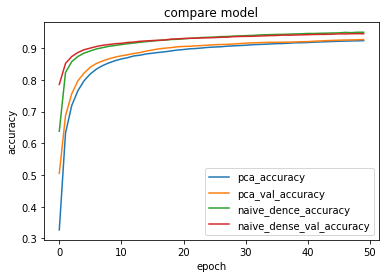

In [ ]:
%matplotlib inline
plt.plot(pca_history.history['accuracy'])
plt.plot(pca_history.history['val_accuracy'])
plt.plot(naive_history.history['accuracy'])
plt.plot(naive_history.history['val_accuracy'])
plt.title('compare model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pca_accuracy', 'pca_val_accuracy', 'naive_dence_accuracy', 'naive_dense_val_accuracy'], loc='lower right')
plt.show()

# Empirical Study 2b
What does the simple dense layer work with the random labeled datasets?

In [ ]:
random_dense = build_model_complex_dense()
random_history = random_dense.fit(x = X_train_Flatten, y=Y_random, epochs=500, steps_per_epoch=100, validation_data=(X_test_Flatten, Y_test))

# The codes below this section will be the CNN network


In [ ]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [ ]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [52]:
def build_model():
  model = Sequential()                                 # Linear stacking of layers
  # Convolution Layer 1
  model.add(Conv2D(32, (3, 3), input_shape=(28,28,1), padding="same")) # 32 different 3x3 kernels -- so 32 feature maps
  model.add(BatchNormalization(axis=-1))
  model.add(Activation('relu'))

  model.add(Conv2D(32, (3, 3), input_shape=(28,28,1), padding="same")) # 32 different 3x3 kernels -- so 32 feature maps
  model.add(Activation('relu'))                     # activation
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3, 3), input_shape=(28,28,1), padding="same")) # 32 different 3x3 kernels -- so 32 feature maps
  model.add(Activation('relu'))
  model.add(BatchNormalization(axis=-1))

  model.add(Conv2D(64, (3, 3), input_shape=(28,28,1), padding="same")) # 32 different 3x3 kernels -- so 32 feature maps
  model.add(Activation('relu'))                     # activation
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D())

  model.add(Flatten())                             # Flatten final layer

  # Fully Connected Layer 6
  model.add(Dense(512))  
  model.add(Dense(10))                                 # final 10 FCN nodes
  model.add(Activation('softmax'))                     # softmax activationss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
  return model

#Third Empirical Study: Unlabeled data take the majority, and verify the pretrained steps.

In [61]:
#Reload the datasets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255


#Futher more, decompose the train set to unlabel train set and label train set. We will try to tranfer the PCA from unlabel dataset to the label dataset.

X_unlabel, X_label, y_unlabel, y_label = train_test_split(X_train, y_train, test_size = 1/3)

def super_random(x):
  y = random.randint(0,9)
  while(y == x):
    y = random.randint(0,9)
  return y

nb_classes = 10

y_shift = y_unlabel + 1
y_shift[y_shift == 10] = 0

Y_unlabel = np_utils.to_categorical(y_unlabel, nb_classes)
Y_label = np_utils.to_categorical(y_label, nb_classes)
Y_random = np_utils.to_categorical([random.randint(0,9) for i in range(40000)], nb_classes)
Y_shift = np_utils.to_categorical(y_shift, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [62]:
#Build the CNN model
CNN_model = build_model()
CNN_model.fit(x=X_unlabel, y = Y_random, epochs=100, validation_data=(X_test, Y_test))

#Freeze some of the layers
'''
for layer in CNN_model.layers[:]:
  layer.trainable = False
for i in range(-4, 0):
  CNN_model.layers[i].trainable= True

model_status(CNN_model)
'''

#Finetune the dense layers
CNN_random_finetune_history = CNN_model.fit(x=X_label, y = Y_label, epochs=50, steps_per_epoch=10, validation_data=(X_test, Y_test))

Epoch 1/100
1250/1250 [==============================] - 6s 5ms/step - loss: 4.1072 - accuracy: 0.1015 - val_loss: 2.3337 - val_accuracy: 0.0907
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3299 - accuracy: 0.1094 - val_loss: 2.2885 - val_accuracy: 0.1483
Epoch 3/100
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3095 - accuracy: 0.1090 - val_loss: 2.3406 - val_accuracy: 0.0887
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3004 - accuracy: 0.1203 - val_loss: 2.2578 - val_accuracy: 0.1512
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 2.2967 - accuracy: 0.1269 - val_loss: 2.2842 - val_accuracy: 0.1530
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 2.2948 - accuracy: 0.1271 - val_loss: 2.3257 - val_accuracy: 0.0926
Epoch 7/100
1250/1250 [==============================] - 5s 4ms/step - loss: 2.2922 - accuracy: 0.1283 - val_loss: 2.3291 - val_ac

In [ ]:
#Build the CNN model
CNN_model = build_model()
CNN_model.fit(x=X_unlabel, y = Y_shift, epochs=100, validation_data=(X_test, Y_test))

'''
#Freeze some of the layers
for layer in CNN_model.layers[:]:
  layer.trainable = False

for i in range(-4, 0):
  CNN_model.layers[i].trainable= True
model_status(CNN_model)
'''

#Finetune the dense layers
CNN_shift_finetune_history = CNN_model.fit(x=X_label, y = Y_label, epochs=50, steps_per_epoch=10, validation_data=(X_test, Y_test))

In [ ]:
CNN_new_model = build_model()
CNN_new_history = CNN_new_model.fit(x=X_label, y = Y_label, epochs=50, steps_per_epoch=10, validation_data=(X_test, Y_test))

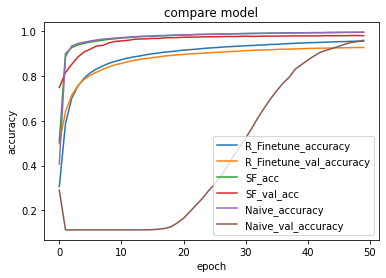

In [65]:
plt.plot(CNN_random_finetune_history.history['accuracy'])
plt.plot(CNN_random_finetune_history.history['val_accuracy'])
plt.plot(CNN_shift_finetune_history.history['accuracy'])
plt.plot(CNN_shift_finetune_history.history['val_accuracy'])
plt.plot(CNN_new_history.history['accuracy'])
plt.plot(CNN_new_history.history['val_accuracy'])
plt.title('compare model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['R_Finetune_accuracy', 'R_Finetune_val_accuracy', 'SF_acc', "SF_val_acc" , 'Naive_accuracy', 'Naive_val_accuracy'], loc='lower right')
plt.show()